Loaded train features from D:\results\Feature extraction\flir dataset\kaist_10_8\train_features.pt - shape:torch.Size([8862, 1792, 8, 10])
Loaded train labels from D:\results\Feature extraction\flir dataset\kaist_10_8\train_features_labels.pt - shape:torch.Size([8862, 1])
Loaded train features from D:\results\Feature extraction\flir dataset\kaist_10_8\valid_features.pt - shape:torch.Size([1366, 1792, 8, 10])
Loaded train labels from D:\results\Feature extraction\flir dataset\kaist_10_8\valid_features_labels.pt - shape:torch.Size([1366, 1])
Validating on device cpu.


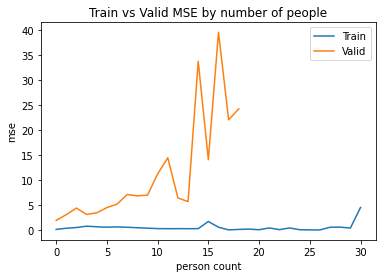

In [5]:
import torch
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from utils import read_data_cfg
from densitynet import DensityNet
import torch.utils.data as D
from density import evaluate,validate

train_dir = pl.Path('D:/results/Feature extraction/flir dataset/kaist_10_8/2021_4_18_12_26_37/')
data_path = 'data/kaist_density.data'
batch_size = 32

options = read_data_cfg(data_path)
nclasses = int(options['classes'])
train_path = pl.Path(options['train'])
valid_path = pl.Path(options['valid'])

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
model = DensityNet(1024,nclasses)
model.load_state_dict(torch.load(train_dir.joinpath('trained_model.pt'),map_location=device))

train_label_path = pl.Path.joinpath(train_path.parent, train_path.stem + '_labels' + train_path.suffix)
t1 = torch.load(train_path, map_location=device)
t1 = t1.reshape(8862, 1792, 8, 10)
t2 = torch.load(train_label_path, map_location=device)
print(f"Loaded train features from {str(train_path)} - shape:{t1.shape}")
print(f"Loaded train labels from {str(train_label_path)} - shape:{t2.shape}")
trainset = list(zip(t1, t2))

# trainset = dataset.featureDataset(train_path, shape=(10, 8),
#                                        shuffle=False,
#                                        )

train_loader = D.DataLoader(trainset, batch_size=batch_size,
                            shuffle=False,drop_last=True)
# test loader
valid_label_path = pl.Path.joinpath(valid_path.parent, valid_path.stem + '_labels' + valid_path.suffix)
v1 = torch.load(valid_path, map_location=device)
v1 = v1.reshape(1366, 1792, 8, 10)
v2 = torch.load(valid_label_path, map_location=device)
print(f"Loaded train features from {str(valid_path)} - shape:{v1.shape}")
print(f"Loaded train labels from {str(valid_label_path)} - shape:{v2.shape}")
valset = list(zip(v1, v2))

# valset = dataset.featureDataset(valid_path, shape=(10, 8),
#                                   shuffle=False,
#                                   )
valid_loader = D.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False,drop_last=True)

# validate(model,train_loader=train_loader,valid_loader=valid_loader,device=device)
predictions = evaluate(model,train_loader,valid_loader,device)

train_predict = predictions['train']
eval_predict = predictions['val']

np.save(pl.Path.joinpath(train_dir, 'mse_train_arr_jp'), train_predict)
np.save(pl.Path.joinpath(train_dir, 'mse_valid_arr_jp'), eval_predict)

mse_train_by_num= [mean_squared_error(train_predict[0,train_predict[0,:,:] == i] \
                                                ,train_predict[1,train_predict[0,:,:] == i]) \
                             for i in np.unique(train_predict[0, :, :])]

mse_val_by_num = [mean_squared_error(eval_predict[0,eval_predict[0,:,:] == i] \
                                       , eval_predict[1,eval_predict[0,:] == i]) \
                    for i in np.unique(eval_predict[0,:,:])]

plt.plot(mse_train_by_num)
plt.plot(mse_val_by_num)
plt.xlabel('person count')
plt.ylabel('mse')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid MSE by number of people')
plt.savefig(pl.Path.joinpath(train_dir,'train_mse_by_people.png'))
# plt.show()

In [ ]:
from datetime import datetime  # <1>
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pathlib as pl
import torch
import torch.utils.data as D
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np

train_losses=[]
valid_losses=[]

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1792, 1024, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=1024)
        self.conv2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=512)
        self.fc1 = nn.Linear(512 * 4 * 5, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1_batchnorm(self.conv1(x))), 2)
        out = torch.tanh(self.conv2_batchnorm(self.conv2(out)))
        out = out.view(-1, 512 * 4 * 5)
        out = torch.tanh(self.fc1(out))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, valid_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.float().to(device=device).unsqueeze(1)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        train_losses.append(loss_train/len(train_loader))
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.now(), epoch,
                loss_train / len(train_loader)))
        test(model,valid_loader,device)

def test(model,valid_loader,device):
    model.eval()

    running_loss = 0.
    correct = 0.
    total = 0.
    loss_fn = nn.MSELoss()

    with torch.no_grad():
        for data,labels in valid_loader:
            data = data.to(device=device)
            labels = labels.to(device=device).unsqueeze(1).float()
            outputs = model(data)

            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            total += labels.size(0)
            # correct += torch.round(outputs).eq(labels).sum().item()

    valid_loss = running_loss / len(valid_loader)
    # accu = 100. * correct / total

    valid_losses.append(valid_loss)

train_path = pl.Path('D:/results/Feature extraction/flir dataset/fm_kaist_density_10_8/kaist_results_train.pt')
valid_path = pl.Path('D:/results/Feature extraction/flir dataset/fm_kaist_density_10_8/kaist_results_valid.pt')

dateTimeObj = datetime.now()

outdir = pl.Path.joinpath(train_path.parent,str(dateTimeObj.year)+ '_' + \
                          str(dateTimeObj.month) + '_' + \
                          str(dateTimeObj.day) + '_' + str(dateTimeObj.hour) + '_' + \
                          str(dateTimeObj.minute) + '_' + str(dateTimeObj.second))


device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

# train loader
train_label_path = pl.Path.joinpath(train_path.parent, train_path.stem + '_labels' + train_path.suffix)
t1 = torch.load(train_path)
t1 = t1.reshape(8862, 1792, 8, 10)
t2 = torch.load(train_label_path).reshape(8862)
print("Loaded train features from {},labels from {}".format(str(train_path),str(train_label_path)))
trainset = list(zip(t1, t2))
train_loader = D.DataLoader(trainset, batch_size=64,
                            shuffle=True)

# test loader
valid_label_path = pl.Path.joinpath(valid_path.parent, valid_path.stem + '_labels' + valid_path.suffix)
v1 = torch.load(valid_path)
v1 = v1.reshape(1366, 1792, 8, 10)
v2 = torch.load(valid_label_path).reshape(1366)
print(f"Loaded valid features from {str(valid_path)},labels from {str(valid_label_path)}")
valset = list(zip(v1, v2))
valid_loader = torch.utils.data.DataLoader(valset, batch_size=64,
                                          shuffle=False)


model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    valid_loader=valid_loader
)

predictions = evaluate(model,train_loader,valid_loader,device)

train_predict = np.array(predictions['train'])
train_predict = train_predict.reshape(2,train_predict.shape[1]).transpose()
eval_predict = np.array(predictions['val'])
eval_predict = eval_predict.reshape(2,eval_predict.shape[1]).transpose()

print(f"Train MSE: {mean_squared_error(train_predict[:,0],train_predict[:,1]):.2f}")
print(f"Valid MSE: {mean_squared_error(eval_predict[:,0],eval_predict[:,1]):.2f}")

if not outdir.exists():
    outdir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), pl.Path.joinpath(outdir, 'trained_model.pt'))

np.save(pl.Path.joinpath(outdir,'mse_train_arr'),train_predict)
np.save(pl.Path.joinpath(outdir,'mse_valid_arr'),eval_predict)

mse_train_by_num= [mean_squared_error(train_predict[train_predict[:, 0] == i][:, 0] \
                                            ,train_predict[train_predict[:, 0] == i][:, 1]) \
                          for i in np.unique(train_predict[:,0])]

mse_val_by_num = [mean_squared_error(eval_predict[eval_predict[:, 0] == i][:, 0] \
                                        , eval_predict[eval_predict[:, 0] == i][:, 1]) \
                    for i in np.unique(eval_predict[:, 0])]

fig = plt.figure()
plt.plot(train_losses)
plt.plot(valid_losses)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses')
plt.savefig(pl.Path.joinpath(outdir,'train_loss.png'))

fig = plt.figure()
plt.plot(mse_train_by_num)
plt.plot(mse_val_by_num)
plt.grid()
plt.xlabel('person count')
plt.ylabel('mse')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid MSE by number of people')
plt.savefig(pl.Path.joinpath(outdir,'train_mse_by_people.png'))
# plt.show()